<a href="https://colab.research.google.com/github/sajad95/Heat/blob/main/MultivariateWithControlOnLengthOfHistoricalDataAndLengthOfPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# predicting Heating Demand Density for a medium office with weather data of winnipeg in 2019

# Multiple Input Multi-Step Output Time series 

# Importing librarires

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pandas import DataFrame
from pandas import concat
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from google.colab import drive
import seaborn as sns

# Loading Data

In [8]:
# mounting google drive and uploading the data
drive.mount('/content/saj')
raw_df = pd.read_csv('/content/saj/MyDrive/Kavgic/2019.csv')

Drive already mounted at /content/saj; to attempt to forcibly remount, call drive.mount("/content/saj", force_remount=True).


In [9]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 35 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Date                                               8760 non-null   object 
 1   Dry Bulb Temperature                               8760 non-null   float64
 2   Dew Point Temperature                              8760 non-null   float64
 3   Relative Humidity                                  8760 non-null   float64
 4   Atmospheric Pressure                               8760 non-null   float64
 5   Extraterrestrial Horizontal Radiation              8760 non-null   int64  
 6   Extraterrestrial Direct Normal Radiation           8760 non-null   int64  
 7   Horizontal Infrared Radiation Intensity from Sky   8760 non-null   float64
 8   Global Horizontal Radiation                        8760 non-null   int64  
 9   Direct N

# Turning day, hour and month to seperate features

In [10]:
def make_time_features(series):
    
    #convert series to datetimes
    times = series.apply(lambda x: x.split('+')[0])
    datetimes = pd.DatetimeIndex(times)
    
    hours = datetimes.hour.values
    day = datetimes.dayofweek.values
    months = datetimes.month.values
    
    hour = pd.Series(hours, name='hours')
    dayofw = pd.Series(day, name='dayofw')
    month = pd.Series(months, name='months')
    
    return hour, dayofw, month

hour, day, month = make_time_features(raw_df.Date)
print("Hours")
print(hour.head())
print("Day of Week")
print(day.head())
print("Months")
print(month.head())

Hours
0    0
1    1
2    2
3    3
4    4
Name: hours, dtype: int64
Day of Week
0    1
1    1
2    1
3    1
4    1
Name: dayofw, dtype: int64
Months
0    1
1    1
2    1
3    1
4    1
Name: months, dtype: int64


In [11]:
hours, day, months = make_time_features(raw_df.Date)
raw_df = pd.concat([raw_df.drop(['Date'], axis=1), hours, day, months], axis=1)

In [12]:
raw_df

Dry Bulb Temperature   Dew Point Temperature   Relative Humidity  \
0                     -21.7                   -26.4               65.0   
1                     -22.2                   -27.0               65.0   
2                     -22.3                   -27.1               65.0   
3                     -24.5                   -28.4               70.0   
4                     -25.2                   -29.0               70.0   
...                     ...                     ...                ...   
8755                  -10.4                   -12.9               82.0   
8756                  -11.0                   -12.9               85.0   
8757                  -10.6                   -13.1               82.0   
8758                  -10.4                   -13.2               80.0   
8759                  -10.3                   -13.1               80.0   

      Atmospheric Pressure  Extraterrestrial Horizontal Radiation  \
0              100430.0000                                      0   
1              100460.0000                                      0   
2              100480.0000                                      0   
3              100480.0000                                      0   
4              100380.0000                                      0   
...                    ...                                    ...   
8755            97240.0000                                      0   
8756            98778.4745                                      0   
8757            97020.0000                                      0   
8758            96900.0000                                      0   
8759            96830.0000                                      0   

      Extraterrestrial Direct Normal Radiation  \
0                                         9999   
1                                         9999   
2                                         9999   
3                                         9999   
4                                         9999   
...                                        ...   
8755                                      9999   
8756                                      9999   
8757                                      9999   
8758                                      9999   
8759                                      9999   

      Horizontal Infrared Radiation Intensity from Sky  \
0                                           176.190523   
1                                           174.333827   
2                                           173.979522   
3                                           166.990586   
4                                           164.676270   
...                                                ...   
8755                                        222.143953   
8756                                        220.120643   
8757                                        221.294437   
8758                                        221.882804   
8759                                        222.308191   

      Global Horizontal Radiation  Direct Normal Radiation  \
0                               0                        0   
1                               0                        0   
2                               0                        0   
3                               0                        0   
4                               0                        0   
...                           ...                      ...   
8755                            0                        0   
8756                            0                        0   
8757                            0                        0   
8758                            0                        0   
8759                            0                        0   

      Diffuse Horizontal Radiation  ...  Liquid Precipitation Quantity  \
0                                0  ...                             99   
1                                0  ...                             99   
2                      

# Data Cleaning

# The data is generated using ENergyPlus so there will be no NaN values

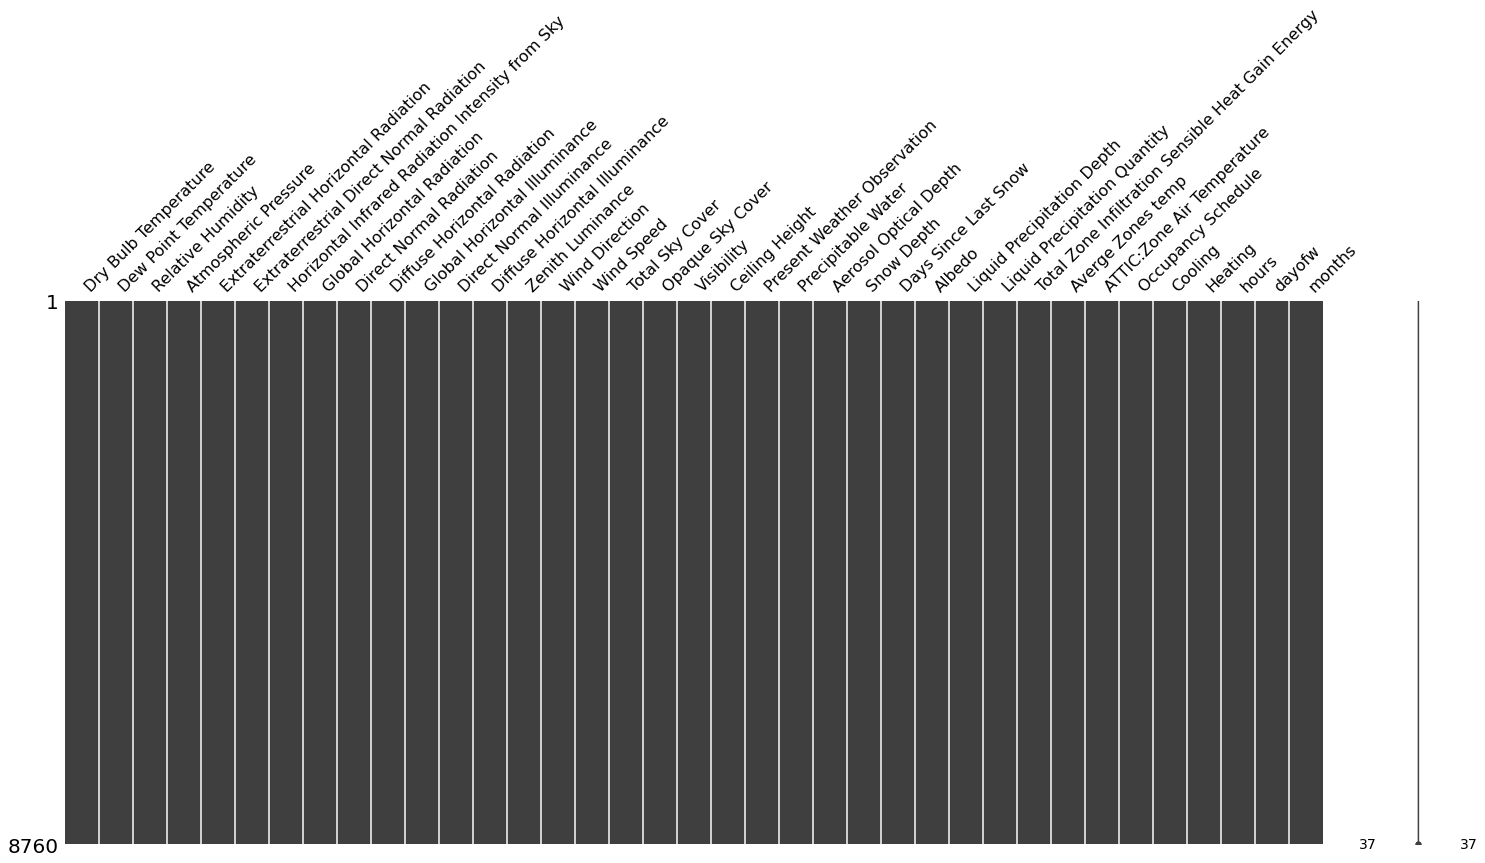

In [13]:
import missingno as msno
msno.matrix(raw_df)
plt.show()

# for now we only care about heating so lets get rid of cooling

In [14]:
raw_df = raw_df.drop(['Cooling'], axis=1)

Text(0, 0.5, 'All Features')

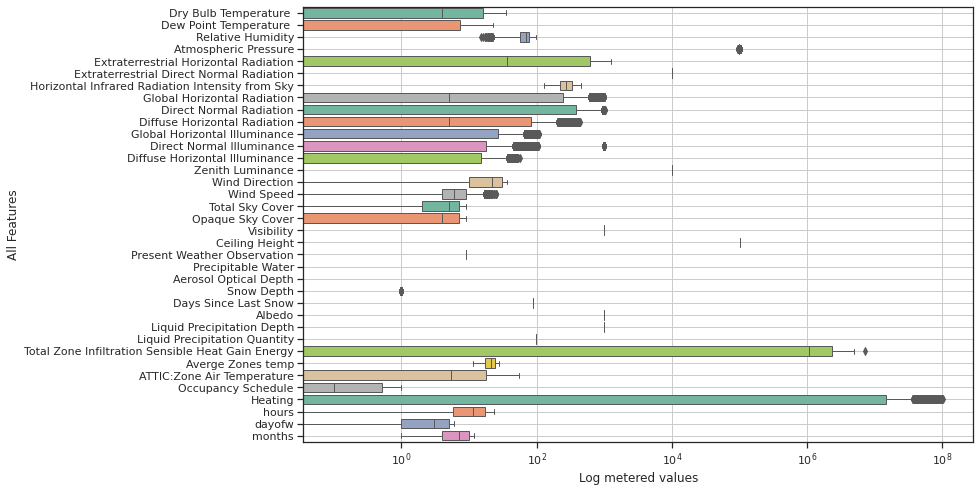

In [15]:
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(12, 8))
ax.set_xscale("log")
ax = sns.boxplot(data=raw_df, orient="h", palette="Set2", linewidth=1)
ax.xaxis.grid(True)
ax.yaxis.grid(True)
#plt.title('Example Plot')
# Set x-axis label
plt.xlabel('Log metered values')
# Set y-axis label
plt.ylabel('All Features')
#boxplot If you used it, you should remove scale = 'linear'
#boxenplot if you used it, you can use scale = 'linear'


## **1. Feature Selection** <a class="anchor" id="1.1"></a>

## **1.1 Basic methods** <a class="anchor" id="1.1"></a>
- Under basic methods, we remove constant and quasi-constant features.
- Constant features are those that show the same value, just one value, for all the observations of the dataset. This is, the same value for all the rows of the dataset. These features provide no information that allows a machine learning model to discriminate or predict a target.

- Identifying and removing constant features, is an easy first step towards feature selection and more easily interpretable machine learning models. To identify constant features, we can use the VarianceThreshold function from sklearn.

- I will demonstrate how to identify constant features using the Santander Customer Satisfaction dataset from Kaggle.

- Source :

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html

- https://scikit-learn.org/stable/modules/feature_selection.html

In [16]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [17]:
X_train = raw_df[:5000]
X_test  = raw_df[5000:8760]

In [18]:
X_train.drop(labels=['Heating'], axis=1, inplace = True)
X_test.drop(labels=['Heating'], axis=1, inplace = True)

In [19]:
X_train.shape, X_test.shape

((5000, 35), (3760, 35))

### **Using variance threshold from sklearn**

- Variance threshold from sklearn is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples.

In [20]:
# using sklearn variancethreshold to find constant features
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(X_train)  # fit finds the features with zero variance

VarianceThreshold(threshold=0)

In [21]:
# get_support is a boolean vector that indicates which features are retained
# if we sum over get_support, we get the number of features that are not constant
sum(sel.get_support())

24

In [22]:
# print the constant features
print(
    len([
        x for x in X_train.columns
        if x not in X_train.columns[sel.get_support()]
    ]))

[x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]

11


['Extraterrestrial Direct Normal Radiation',
 'Zenith Luminance',
 'Visibility',
 'Ceiling Height',
 'Present Weather Observation',
 'Precipitable Water',
 'Aerosol Optical Depth',
 'Days Since Last Snow',
 'Albedo',
 'Liquid Precipitation Depth',
 'Liquid Precipitation Quantity']

- We then use the transform function to reduce the training and testing sets.

In [23]:
# we can then drop these columns from the train and test sets
X_train_trans_remove_cons = sel.transform(X_train)
X_test_trans_remove_cons = sel.transform(X_test)

In [24]:
X_train_trans_remove_cons.shape, X_test_trans_remove_cons.shape

((5000, 24), (3760, 24))

## **1.1.2 Remove quasi-constant features** <a class="anchor" id="2.1.2"></a>

[Table of Contents](#0.1)

- Quasi-constant features are those that show the same value for the great majority of the observations of the dataset. In general, these features provide little if any information that allows a machine learning model to discriminate or predict a target. But there can be exceptions. So we should be careful when removing these type of features. Identifying and removing quasi-constant features, is an easy first step towards feature selection and more easily interpretable machine learning models.

- To identify quasi-constant features, we can once again use the VarianceThreshold function from sklearn.

- Here I will demonstrate how to identify quasi-constant features using the Santander Customer Satisfaction dataset.

In [25]:
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(X_train)  # fit finds the features with low variance

VarianceThreshold(threshold=0.01)

In [26]:
# get_support is a boolean vector that indicates which features 
# are retained. If we sum over get_support, we get the number
# of features that are not quasi-constant
sum(sel.get_support())

24

In [27]:
# finally we can print the quasi-constant features
print(
    len([
        x for x in X_train.columns
        if x not in X_train.columns[sel.get_support()]
    ]))

[x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]

11


['Extraterrestrial Direct Normal Radiation',
 'Zenith Luminance',
 'Visibility',
 'Ceiling Height',
 'Present Weather Observation',
 'Precipitable Water',
 'Aerosol Optical Depth',
 'Days Since Last Snow',
 'Albedo',
 'Liquid Precipitation Depth',
 'Liquid Precipitation Quantity']

- We can see that 11 columns / variables are almost constant. This means that 11 variables show predominantly one value for ~99% the observations of the training set.

In [28]:
# percentage of observations showing each of the different values
X_train['Extraterrestrial Direct Normal Radiation'].value_counts() / np.float(len(X_train))

9999    1.0
Name: Extraterrestrial Direct Normal Radiation, dtype: float64

- We can see that > 99% of the observations show one value, 9999. Therefore, this feature is almost constant.

In [29]:
# we can then remove the features from training and test set
X_train_quasi = sel.transform(X_train)
X_test_quasi = sel.transform(X_test)

In [30]:
# check the shape of training and test set
X_train_quasi.shape, X_test_quasi.shape

((5000, 24), (3760, 24))

## **1.2 Correlation-Matrix with Heatmap** <a class="anchor" id="2.6"></a>

[Table of Contents](#0.1)


- **Correlation** is a measure of the linear relationship of 2 or more variables. Through correlation, we can predict one variable from the other.

- **Good variables are highly correlated with the target**.

- Correlated predictor variables provide redundant information.

- **Variables should be correlated with the target but uncorrelated among themselves**.


- Correlation Feature Selection evaluates subsets of features on the basis of the following hypothesis: 

   - "Good feature subsets contain features highly correlated with the target, yet uncorrelated to each other".
   
   
- In this section,  I will demonstrate how to select features based on correlation between two features. We can find features that are correlated with each other. By identifying these features, we can then decide which features we want to keep, and which ones we want to remove.

In [31]:
pearsoncorr = raw_df.corr(method = 'pearson')
A = pearsoncorr
A

Dry Bulb Temperature   \
Dry Bulb Temperature                                            1.000000   
Dew Point Temperature                                           0.947987   
Relative Humidity                                              -0.403808   
Atmospheric Pressure                                           -0.481247   
Extraterrestrial Horizontal Radiation                           0.326954   
Extraterrestrial Direct Normal Radiation                             NaN   
Horizontal Infrared Radiation Intensity from Sky                0.983339   
Global Horizontal Radiation                                     0.297714   
Direct Normal Radiation                                         0.200645   
Diffuse Horizontal Radiation                                    0.335911   
Global Horizontal Illuminance                                   0.322745   
Direct Normal Illuminance                                       0.004739   
Diffuse Horizontal Illuminance                                  0.280332   
Zenith Luminance                                                     NaN   
Wind Direction                                                 -0.130976   
Wind Speed                                                     -0.061205   
Total Sky Cover                                                 0.005974   
Opaque Sky Cover                                               -0.311410   
Visibility                                                           NaN   
Ceiling Height                                                       NaN   
Present Weather Observation                                          NaN   
Precipitable Water                                                   NaN   
Aerosol Optical Depth                                                NaN   
Snow Depth                                                     -0.682207   
Days Since Last Snow                                                 NaN   
Albedo                                                               NaN   
Liquid Precipitation Depth                                           NaN   
Liquid Precipitation Quantity                                        NaN   
Total Zone Infiltration Sensible Heat Gain Energy              -0.112833   
Averge Zones temp                                               0.839152   
ATTIC:Zone Air Temperature                                      0.923306   
Occupancy Schedule                                              0.040707   
Heating                                                        -0.627877   
hours                                                           0.098525   
dayofw                                                          0.004553   
months                                                          0.249667   

                                                   Dew Point Temperature   \
Dry Bulb Temperature                                             0.947987   
Dew Point Temperature                                            1.000000   
Relative Humidity                                               -0.099725   
Atmospheric Pressure                                            -0.537513   
Extraterrestrial Horizontal Radiation                            0.223775   
Extraterrestrial Direct Normal Radiation                              NaN   
Horizontal Infrared Radiation Intensity from Sky                 0.948850   
Global Horizontal Radiation                                      0.211537   
Direct Normal Radiation                                          0.052031   
Diffuse Horizontal Radiation                                     0.230709   
Global Horizontal Illuminance                                    0.225557   
Direct Normal Illuminance                                        0.007173   
Diffuse Horizontal Illuminance                                   0.180622   
Zenith Luminance                                                      NaN   
Wind Direction                                                  -0.117705   
Wind S

## The NaN, in this case, is interpreted as no correlation between the two variables. The correlation describes how much one variable changes as the other variable changes. That requires both variables to change.

* Some of the reason for the occurrence of nan values in your output might be because:

Input consists of nan values
One of the input must have identical values like y=[-0.414;-0.414;-0.414]
To explain with an example:

Consider two variables x and y:
x=[-7.501899598769999514e-04;-6.501899598769999514e-04;-5.501899598769999514e-04];
y=[-0.414;-0.414;-0.414]

The output will definitely contain nan values because!



If you look at the equations for Pearson correlation you'll notice that both have a term in the denominator that subtracts the mean of y from each y-value. When each value of y is identical, the result is a vector of 0s. When you divide by zero, you get NaN.

The NaN, in this case, is interpreted as no correlation between the two variables.

* https://www.kaggle.com/general/186524

# So we will eliminate the coloumns that have no corelation with heating

In [32]:
filtered_df = A['Heating']
X = filtered_df[A['Heating'].isna()]
X

Extraterrestrial Direct Normal Radiation   NaN
Zenith Luminance                           NaN
Visibility                                 NaN
Ceiling Height                             NaN
Present Weather Observation                NaN
Precipitable Water                         NaN
Aerosol Optical Depth                      NaN
Days Since Last Snow                       NaN
Albedo                                     NaN
Liquid Precipitation Depth                 NaN
Liquid Precipitation Quantity              NaN
Name: Heating, dtype: float64

In [33]:
raw_df=raw_df.drop(['Extraterrestrial Direct Normal Radiation', 'Zenith Luminance', 'Visibility','Ceiling Height','Present Weather Observation',
                   'Precipitable Water','Aerosol Optical Depth','Days Since Last Snow','Albedo','Liquid Precipitation Depth','Liquid Precipitation Quantity'],axis=1 )

In [34]:
pearsoncorr = raw_df.corr(method = 'pearson')

In [35]:
import seaborn as seabornInstance

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5]), <a list of 25 Text major ticklabel objects>)

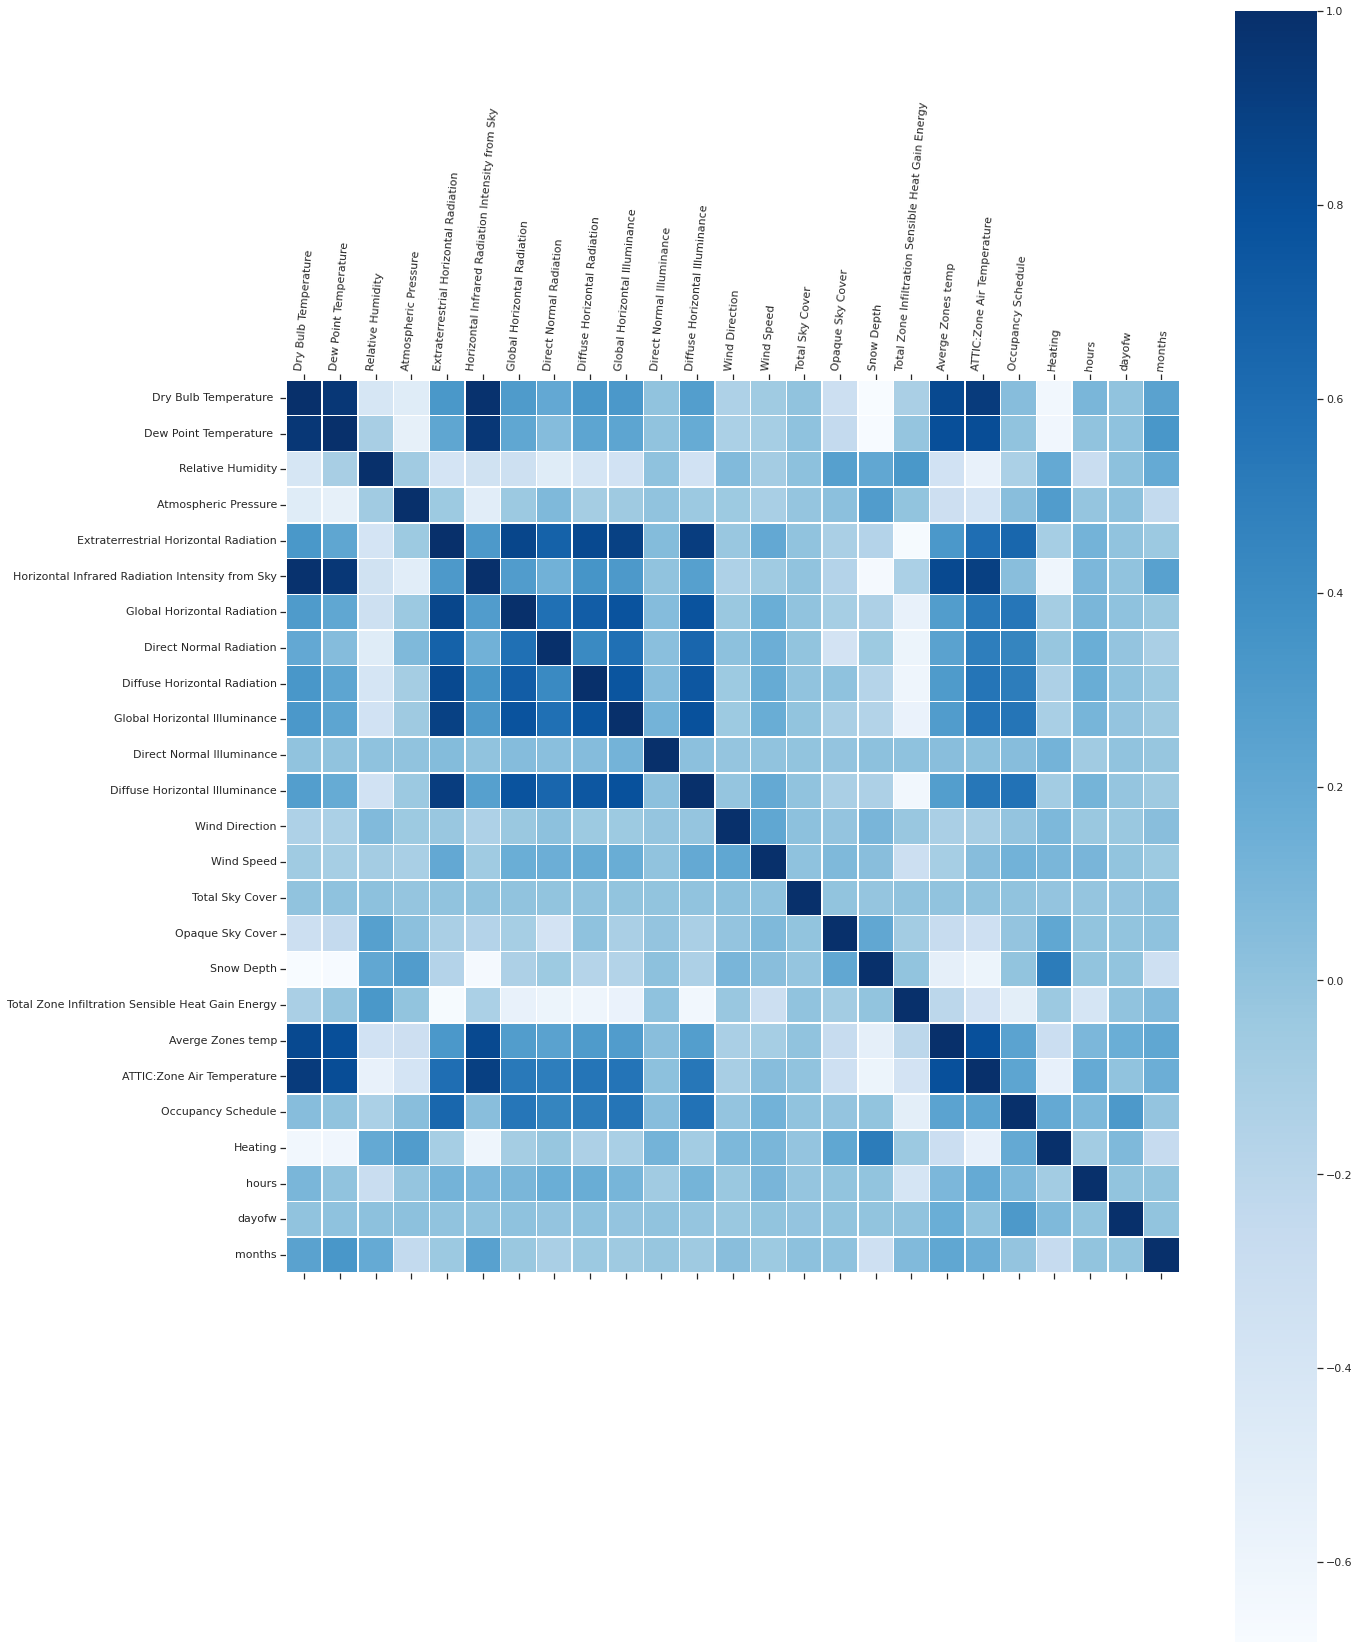

In [36]:
corr = raw_df.corr()
fig, ax=fig, ax = plt.subplots(figsize= (20,30))
cax = ax.matshow(corr,cmap='Blues', vmin=-1, vmax=1)
seabornInstance.heatmap(pearsoncorr, xticklabels=pearsoncorr.columns, yticklabels=pearsoncorr.columns, cmap='Blues', annot=False, linewidth= 0.5 )
plt.xticks(rotation=85)

# **2. Wrapper Methods** <a class="anchor" id="3"></a>

[Table of Contents](#0.1)


- In wrapper methods, we try to use a subset of features and train a model using them. Based on the inferences that we draw from the previous model, we decide to add or remove features from the subset. The problem is essentially reduced to a search problem. These methods are usually computationally very expensive.

- Some common examples of wrapper methods are 

  - 1. Forward selection, 
  - 2. Backward elimination, 
  - 3. Exhaustive feature selection,
  - 4. Recursive feature elimination.
  - 5. Recursive feature elimination with cross-validation
  
  
- Wrapper methods can be explained with the help of following graphic:

## **2.1 Forward Selection** <a class="anchor" id="3.1"></a>

[Table of Contents](#0.1) 


- Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.

- The procedure starts with an empty set of features [reduced set]. The best of the original features is determined and added to the reduced set. At each subsequent iteration, the best of the remaining original attributes is added to the set.

- Step forward feature selection starts by evaluating all features individually and selects the one that generates the best performing algorithm, according to a pre-set evaluation criteria. In the second step, it evaluates all possible combinations of the selected feature and a second feature, and selects the pair that produce the best performing algorithm based on the same pre-set criteria.

- The pre-set criteria can be the roc_auc for classification and the r squared for regression for example.

- This selection procedure is called greedy, because it evaluates all possible single, double, triple and so on feature combinations. Therefore, it is quite computationally expensive, and sometimes, if feature space is big, even unfeasible.

- There is a special package for python that implements this type of feature selection: mlxtend.

- In the mlxtend implementation of the step forward feature selection, the stopping criteria is an arbitrarily set number of features. So the search will finish when we reach the desired number of selected features.


In [37]:
# step forward feature selection

!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
raw_df_wrapper = raw_df.drop(['Heating'], axis=1)

In [39]:
y_train = raw_df['Heating'][:5000]

In [40]:
# Splitting the data
X_train = raw_df_wrapper[:5000]
X_test  = raw_df_wrapper[5000:8760]

In [41]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('the number of correlated features is: ', len(set(corr_features)) )
corr_features

the number of correlated features is:  9


{'ATTIC:Zone Air Temperature',
 'Averge Zones temp',
 'Dew Point Temperature ',
 'Diffuse Horizontal Illuminance',
 'Diffuse Horizontal Radiation',
 'Global Horizontal Illuminance',
 'Global Horizontal Radiation',
 'Horizontal Infrared Radiation Intensity from Sky',
 'months'}

In [42]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)
X_train.shape, X_test.shape

((5000, 15), (3760, 15))

In [43]:
# step forward feature selection

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(RandomForestRegressor(), 
           k_features=6, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=3)

sfs1 = sfs1.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   15.4s finished

[2023-01-30 15:21:32] Features: 1/6 -- score: -0.6697850683378626[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   19.8s finished

[2023-01-30 15:21:51] Features: 2/6 -- score: -0.403196187398168[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   20.2s finished

[2023-01-30 15:22:11] Features: 3/6 -- score: -0.19530974383293834[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [44]:
sfs1.k_feature_idx_

(0, 5, 7, 10, 12, 14)

In [45]:
X_train.columns[list(sfs1.k_feature_idx_)]

Index(['Dry Bulb Temperature ', 'Direct Normal Illuminance', 'Wind Speed',
       'Snow Depth', 'Occupancy Schedule', 'dayofw'],
      dtype='object')

## **2.2 Backward Elimination** <a class="anchor" id="3.2"></a>

[Table of Contents](#0.1) 


- In backward elimination, we start with all the features and removes the least significant feature at each iteration which improves the performance of the model. We repeat this until no improvement is observed on removal of features.

- The procedure starts with the full set of attributes. At each step, it removes the worst attribute remaining in the set.

In [46]:
# step backward feature elimination

sfs1 = SFS(RandomForestRegressor(), 
           k_features=6, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=3)

sfs1 = sfs1.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.2min finished

[2023-01-30 15:24:40] Features: 14/6 -- score: -3.1927277979746287[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  1.1min finished

[2023-01-30 15:25:47] Features: 13/6 -- score: -0.32310230464850703[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   57.8s finished

[2023-01-30 15:26:44] Features: 12/6 -- score: -0.25435076284112884[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: D

In [ ]:
sfs1.k_feature_idx_

(0, 2, 4, 10, 12, 14)

In [ ]:
X_train.columns[list(sfs1.k_feature_idx_)]

Index(['Dry Bulb Temperature ', 'Atmospheric Pressure',
       'Direct Normal Radiation', 'Snow Depth', 'Occupancy Schedule',
       'dayofw'],
      dtype='object')

# Picking featurs manually
* no algorithm is more intelligent than human 

In [ ]:
raw_df

Dry Bulb Temperature   Dew Point Temperature   Relative Humidity  \
0                     -21.7                   -26.4               65.0   
1                     -22.2                   -27.0               65.0   
2                     -22.3                   -27.1               65.0   
3                     -24.5                   -28.4               70.0   
4                     -25.2                   -29.0               70.0   
...                     ...                     ...                ...   
8755                  -10.4                   -12.9               82.0   
8756                  -11.0                   -12.9               85.0   
8757                  -10.6                   -13.1               82.0   
8758                  -10.4                   -13.2               80.0   
8759                  -10.3                   -13.1               80.0   

      Atmospheric Pressure  Extraterrestrial Horizontal Radiation  \
0              100430.0000                                      0   
1              100460.0000                                      0   
2              100480.0000                                      0   
3              100480.0000                                      0   
4              100380.0000                                      0   
...                    ...                                    ...   
8755            97240.0000                                      0   
8756            98778.4745                                      0   
8757            97020.0000                                      0   
8758            96900.0000                                      0   
8759            96830.0000                                      0   

      Horizontal Infrared Radiation Intensity from Sky  \
0                                           176.190523   
1                                           174.333827   
2                                           173.979522   
3                                           166.990586   
4                                           164.676270   
...                                                ...   
8755                                        222.143953   
8756                                        220.120643   
8757                                        221.294437   
8758                                        221.882804   
8759                                        222.308191   

      Global Horizontal Radiation  Direct Normal Radiation  \
0                               0                        0   
1                               0                        0   
2                               0                        0   
3                               0                        0   
4                               0                        0   
...                           ...                      ...   
8755                            0                        0   
8756                            0                        0   
8757                            0                        0   
8758                            0                        0   
8759                            0                        0   

      Diffuse Horizontal Radiation  Global Horizontal Illuminance  ...  \
0                                0                              0  ...   
1                                0                              0  ...   
2                                0                              0  ...   
3                                0                              0  ...   
4                                0                              0  ...   
...                            ...                            ...  ...   
8755                             0                              0  ...   
8756                             0                              0  ...   
8757                             0                              0  ...   
8758                             0                              0  ...   
8759                            

In [66]:
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df

# sending the heating to the end

In [ ]:
raw_df = df_column_switch(raw_df,'Heating','months')
raw_df

Dry Bulb Temperature   Dew Point Temperature   Relative Humidity  \
0                     -21.7                   -26.4               65.0   
1                     -22.2                   -27.0               65.0   
2                     -22.3                   -27.1               65.0   
3                     -24.5                   -28.4               70.0   
4                     -25.2                   -29.0               70.0   
...                     ...                     ...                ...   
8755                  -10.4                   -12.9               82.0   
8756                  -11.0                   -12.9               85.0   
8757                  -10.6                   -13.1               82.0   
8758                  -10.4                   -13.2               80.0   
8759                  -10.3                   -13.1               80.0   

      Atmospheric Pressure  Extraterrestrial Horizontal Radiation  \
0              100430.0000                                      0   
1              100460.0000                                      0   
2              100480.0000                                      0   
3              100480.0000                                      0   
4              100380.0000                                      0   
...                    ...                                    ...   
8755            97240.0000                                      0   
8756            98778.4745                                      0   
8757            97020.0000                                      0   
8758            96900.0000                                      0   
8759            96830.0000                                      0   

      Horizontal Infrared Radiation Intensity from Sky  \
0                                           176.190523   
1                                           174.333827   
2                                           173.979522   
3                                           166.990586   
4                                           164.676270   
...                                                ...   
8755                                        222.143953   
8756                                        220.120643   
8757                                        221.294437   
8758                                        221.882804   
8759                                        222.308191   

      Global Horizontal Radiation  Direct Normal Radiation  \
0                               0                        0   
1                               0                        0   
2                               0                        0   
3                               0                        0   
4                               0                        0   
...                           ...                      ...   
8755                            0                        0   
8756                            0                        0   
8757                            0                        0   
8758                            0                        0   
8759                            0                        0   

      Diffuse Horizontal Radiation  Global Horizontal Illuminance  ...  \
0                                0                              0  ...   
1                                0                              0  ...   
2                                0                              0  ...   
3                                0                              0  ...   
4                                0                              0  ...   
...                            ...                            ...  ...   
8755                             0                              0  ...   
8756                             0                              0  ...   
8757                             0                              0  ...   
8758                             0                              0  ...   
8759                            

In [ ]:
raw_df.columns.get_loc('Heating')

24

In [ ]:
raw_df1= raw_df.iloc[:,:]
raw_df1.shape

(8760, 25)

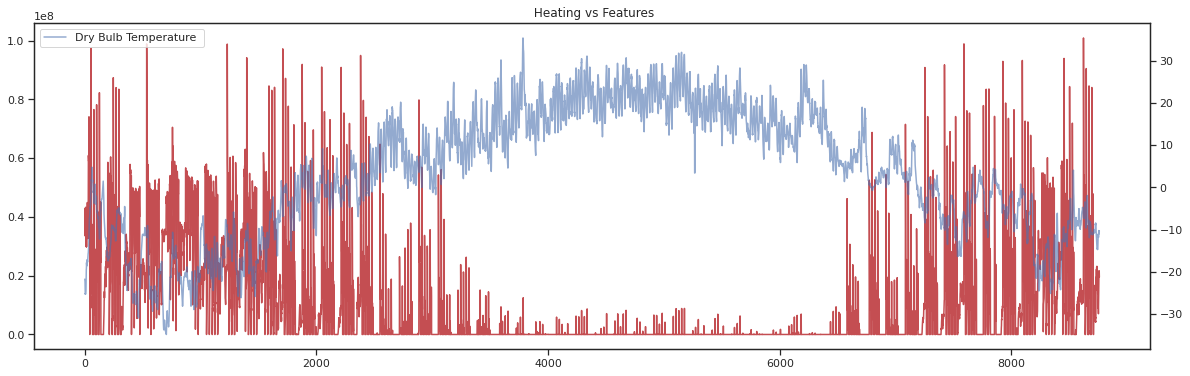

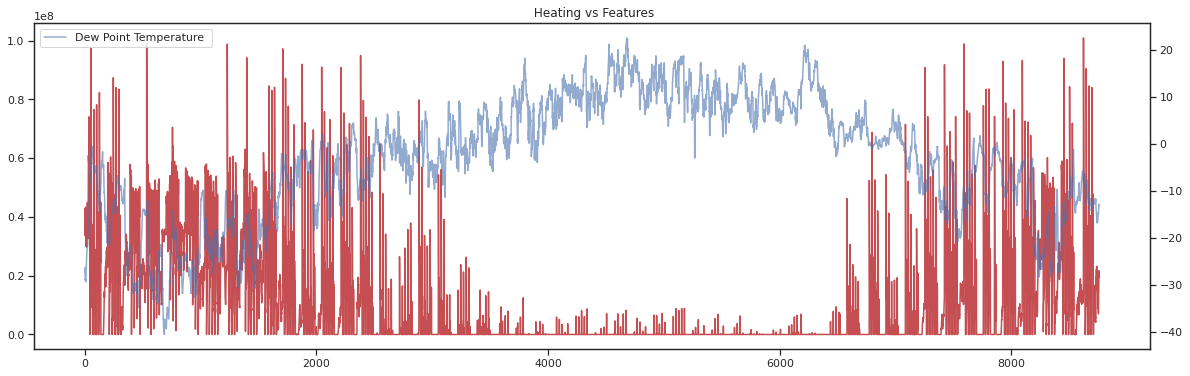

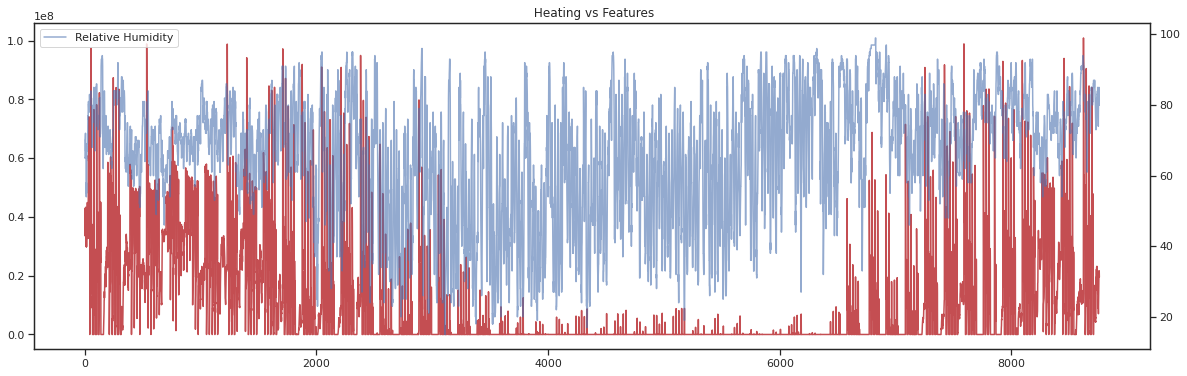

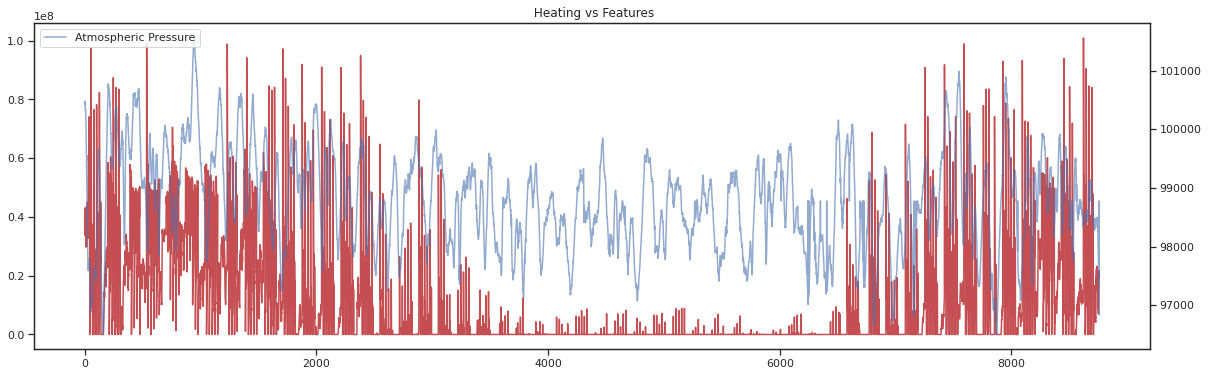

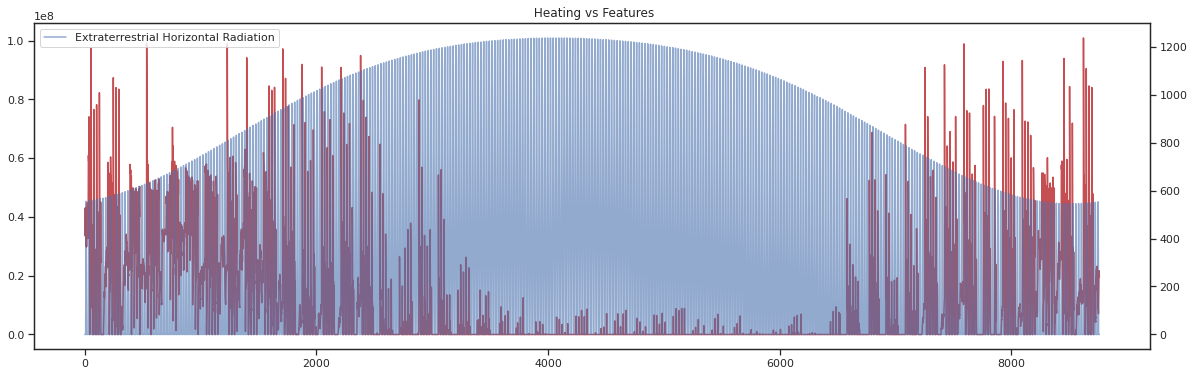

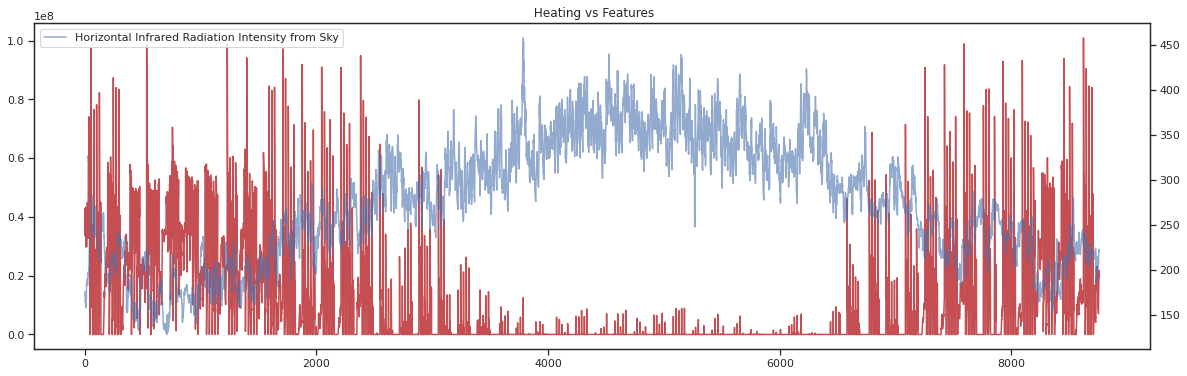

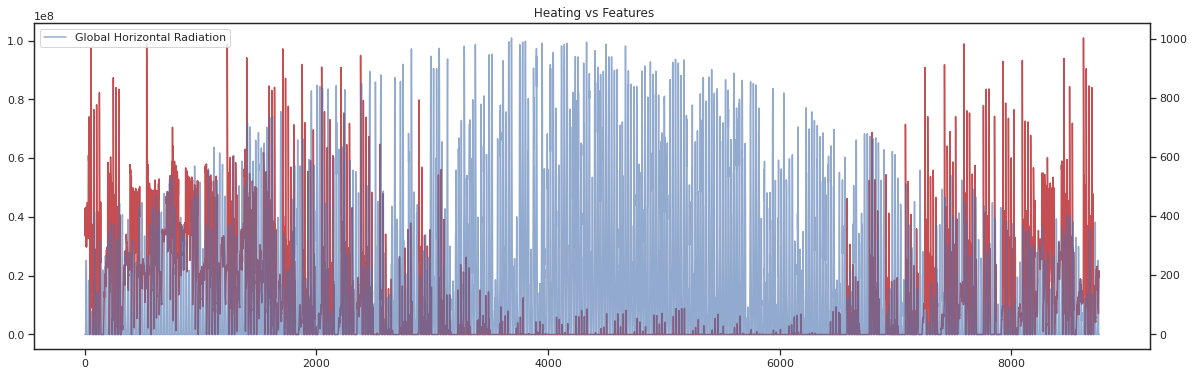

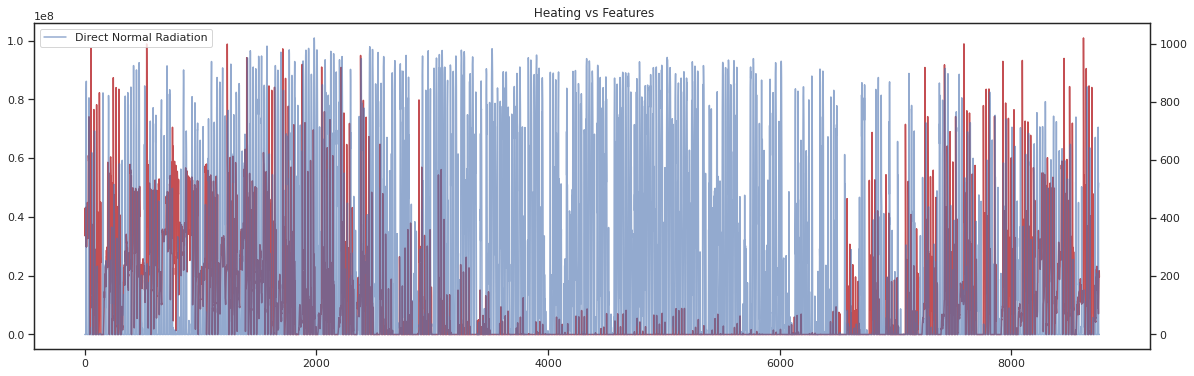

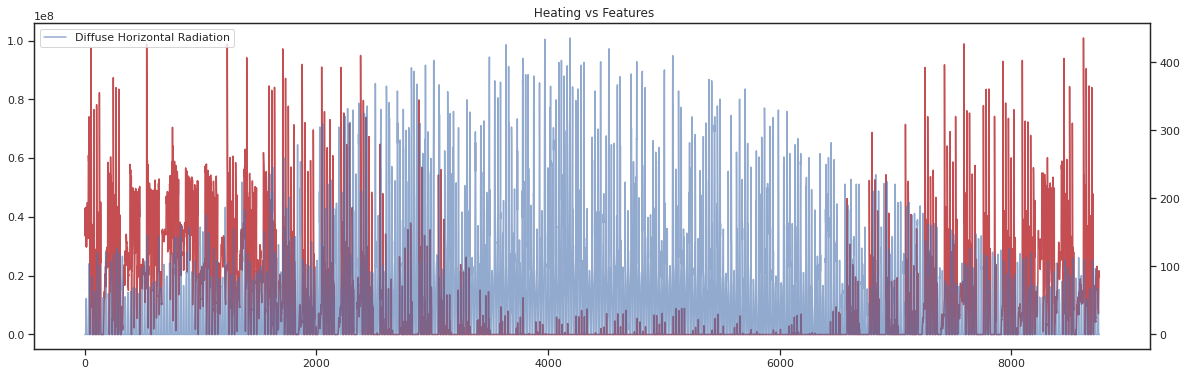

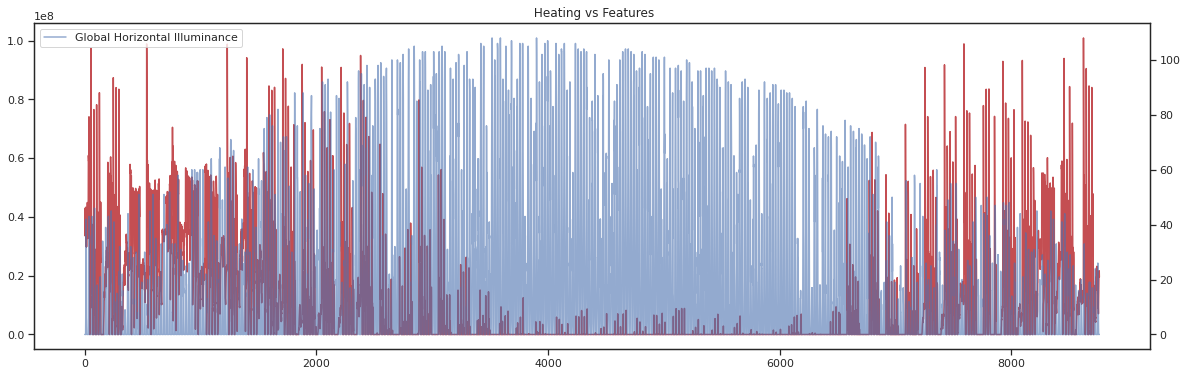

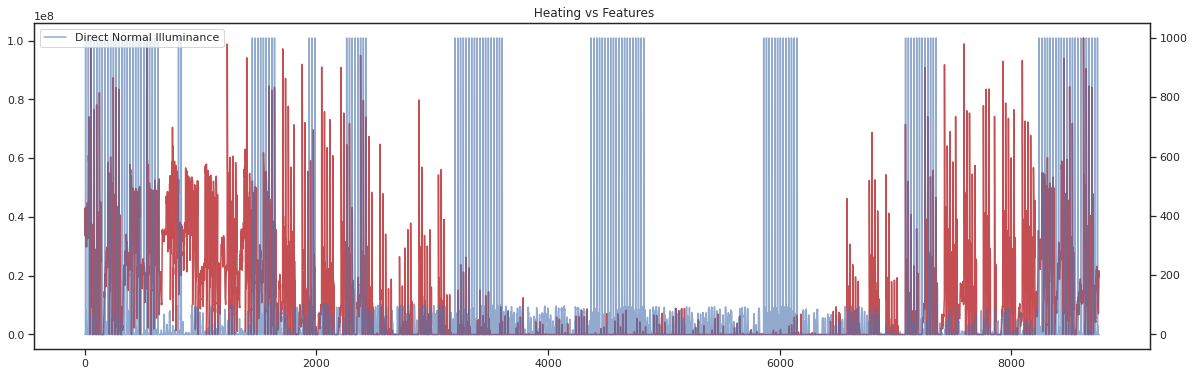

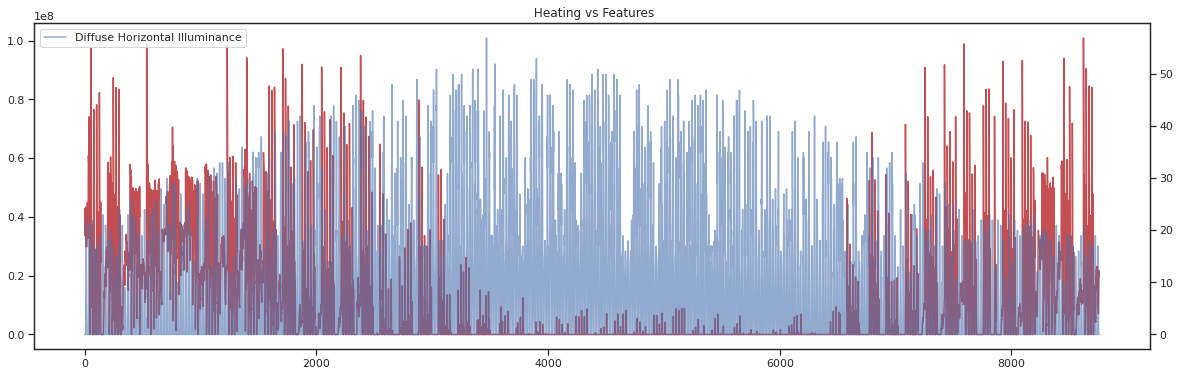

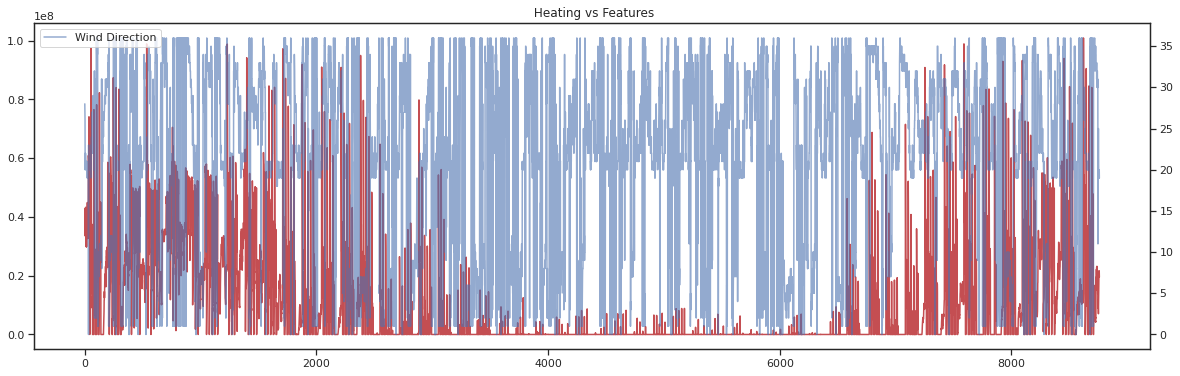

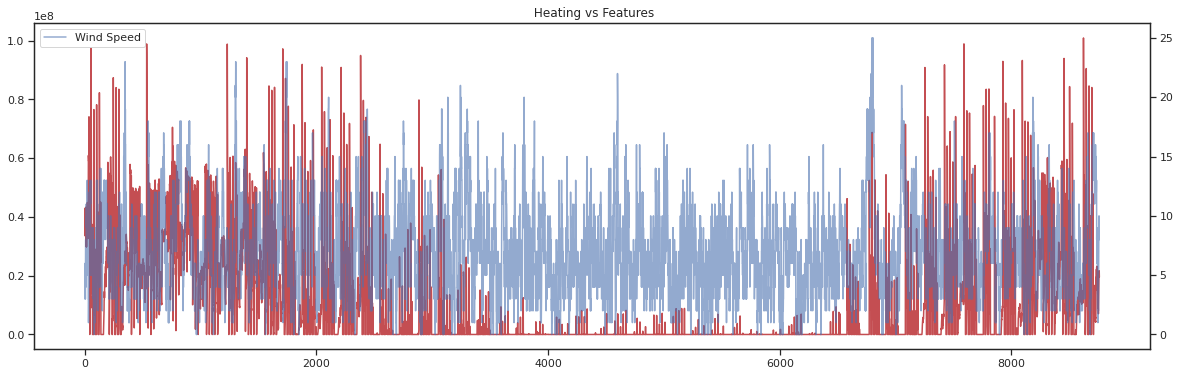

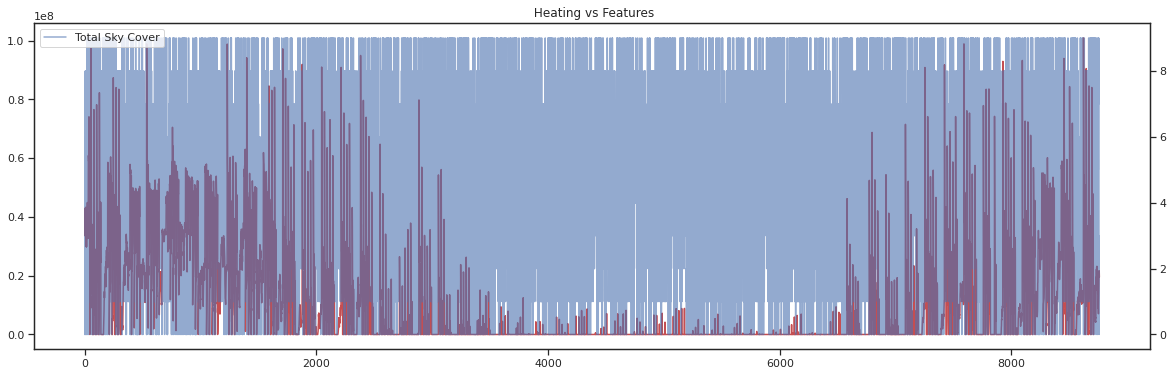

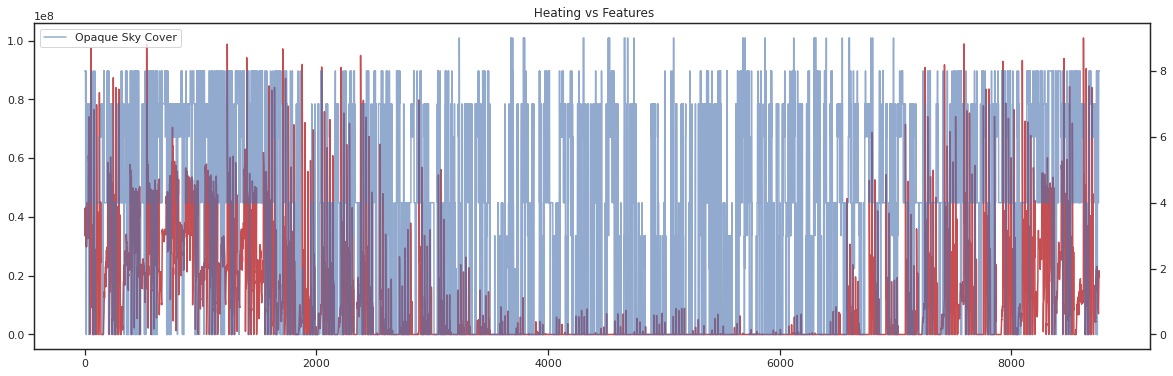

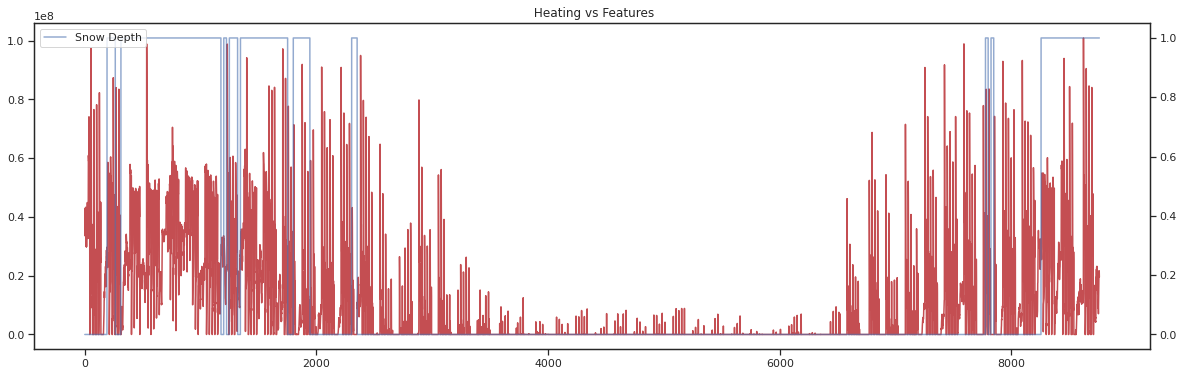

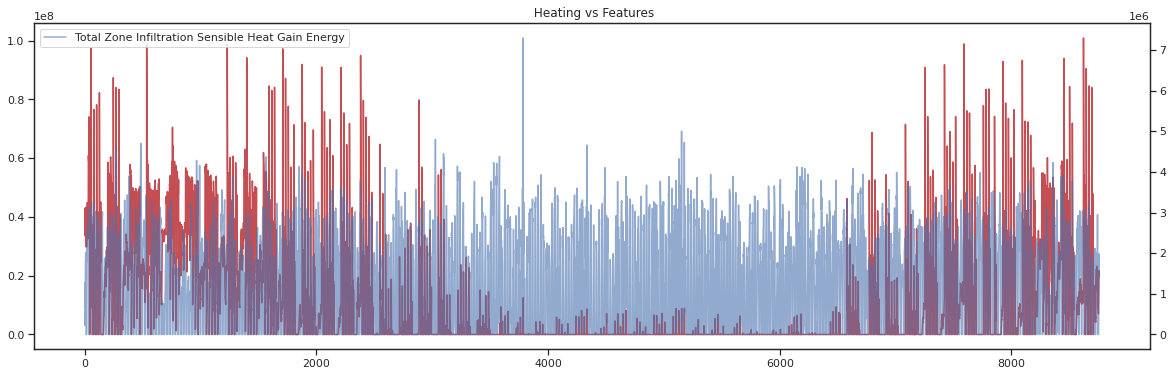

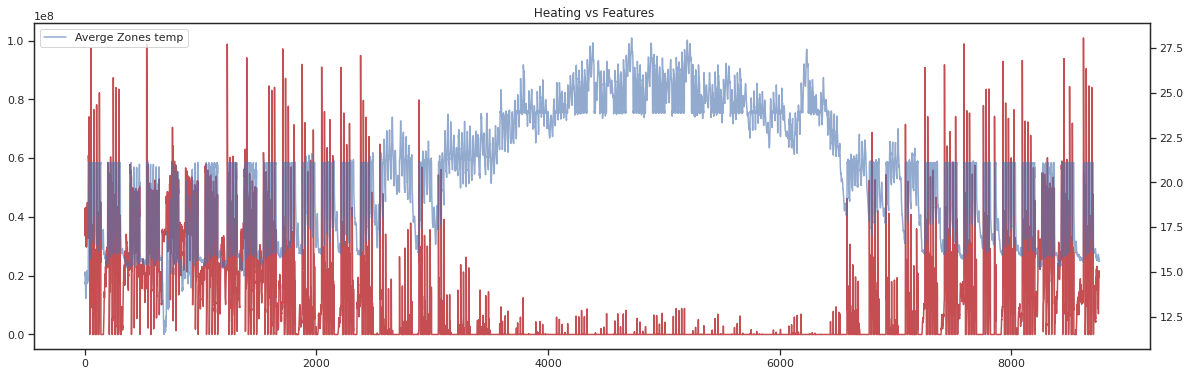

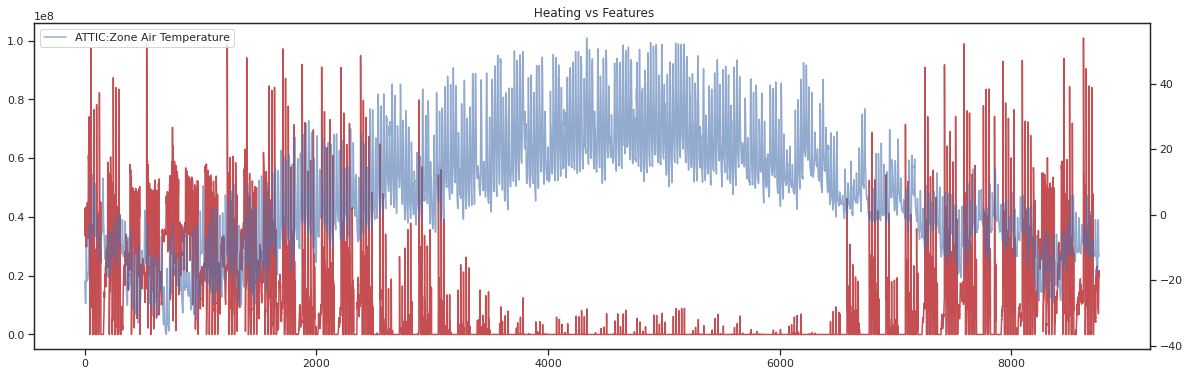

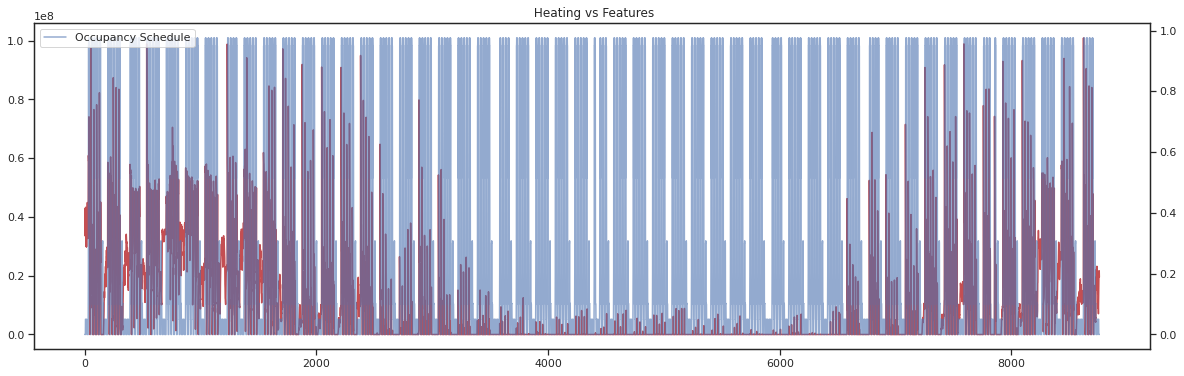

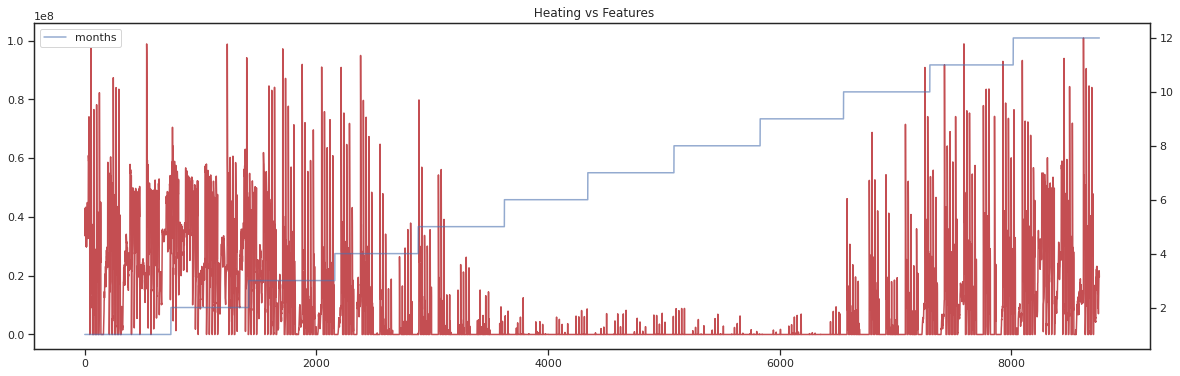

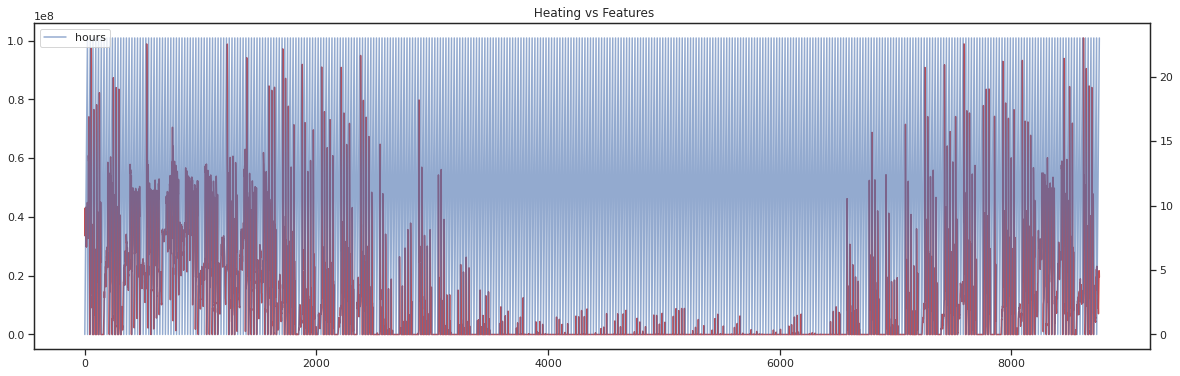

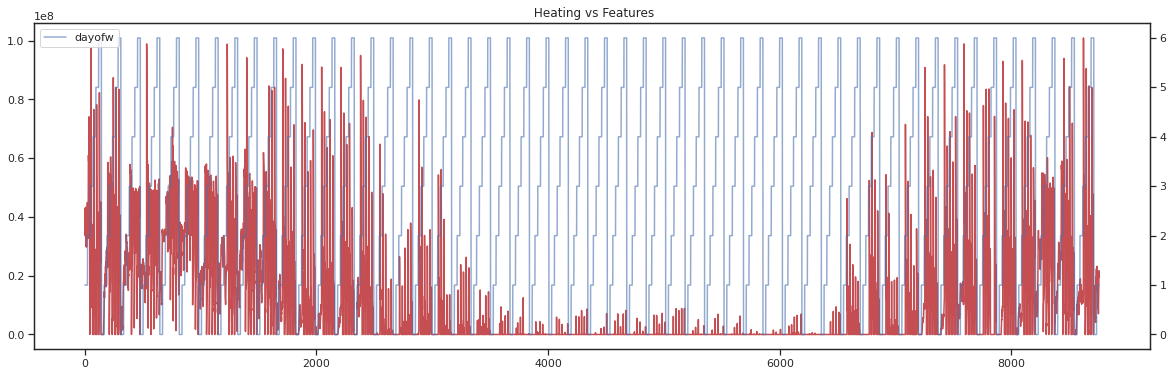

In [ ]:
# y1 is heating
plt.ion()
y1 = raw_df1.iloc[:,24]
A = list(raw_df1)
for i in range(24):
  y2 = raw_df1.iloc[:,i]
  x_ax = range (len(raw_df1['Heating']))
  fig, ax1 = plt.subplots(figsize=(20,6))
  #Adding another y axis
  ax2 = ax1.twinx()
  ax1.plot(x_ax, y1, 'r-')
  ax2.plot(x_ax, y2, 'b-', alpha = 0.6 , label = A [i])
  plt.title(" Heating vs Features")

  plt.legend(loc='upper left')#Upper right , 
  plt.show()

# With regard to these figures and my knowldge, I chose : day of week , Occupancy schedule, Dry bulb temperature

# Developing the LSTM model, lets load data again

In [429]:
def load_data(col=None, path="/content/saj/MyDrive/Kavgic/medium office with weather data of winnipeg at 2019 (1).csv", verbose=False):
    df = pd.read_csv(path)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df
print("Multivariate Sample")
multivar_df = load_data(['Date','Outdoor Air Temperature','Occupancy Schedule','Heating'], verbose = True ) 

Multivariate Sample
                            Date  Outdoor Air Temperature  Occupancy Schedule  \
0  2019-01-01 00:00:00.000 +0100               -19.908333                 0.0   
1  2019-01-01 01:00:00.000 +0100               -21.991667                 0.0   
2  2019-01-01 02:00:00.000 +0100               -22.258333                 0.0   
3  2019-01-01 03:00:00.000 +0100               -23.583333                 0.0   
4  2019-01-01 04:00:00.000 +0100               -24.908333                 0.0   

       Heating  
0  267154686.3  
1  209272895.3  
2  253343288.9  
3  207051480.5  
4  271259344.5  


# Scaling the energy and obtaining the HDD

* The Goal is to predcit the heat demand density which is total energy devided by the area with a unit of kj/m2
* The Area of meduim office is 4979 m2
* Also we are going to use Kj as  the unit for energy. By doing so, the order of energy from 1e8 will decrease to 1e2 which is close to order of other features

In [430]:
multivar_df['Heating'] = multivar_df['Heating'] / (4979*1e3)
multivar_df.describe()

Outdoor Air Temperature  Occupancy Schedule      Heating
count              8760.000000         8760.000000  8760.000000
mean                  3.431443            0.282495    21.066725
std                  14.754958            0.382685    37.249883
min                 -34.633333            0.000000     0.000000
25%                  -7.868750            0.000000     0.000000
50%                   3.970833            0.100000     0.000000
75%                  16.008333            0.513528    26.483564
max                  35.283333            0.975703   195.280847

In [431]:
multivar_df['Date'] = multivar_df['Date'].astype(str)

In [432]:
hour, day, month = make_time_features(multivar_df.Date)

In [433]:
multivar_df = pd.concat([multivar_df.drop(['Date'], axis=1), hours, day, months], axis=1)
multivar_df = multivar_df.drop(['hours','months'], axis = 1)
multivar_df

Outdoor Air Temperature  Occupancy Schedule     Heating  dayofw
0                  -19.908333                 0.0   53.656294       1
1                  -21.991667                 0.0   42.031110       1
2                  -22.258333                 0.0   50.882364       1
3                  -23.583333                 0.0   41.584953       1
4                  -24.908333                 0.0   54.480688       1
...                       ...                 ...         ...     ...
8755               -10.316667                 0.0  104.452737       1
8756               -10.750000                 0.0  106.838946       1
8757               -10.766667                 0.0  107.711173       1
8758               -10.483333                 0.0    0.000000       1
8759               -10.341667                 0.0    1.034563       1

[8760 rows x 4 columns]

In [434]:
multivar_df = df_column_switch(multivar_df, 'Heating', 'dayofw')

# Baseline Error Performance

In order to compare model perofrmance we need an estimate of bayes limit for the problem. In this case we do not have a human error reference. So we use the the lowest of the following:

- Persistance 1 Day. Using the observed values from the previous days as the prediction of the next day.
- Persistance 3 day mean. Using the observations from the previous 3 days as the prediction of the next day.

By establishing a baseline error we have a refernce to compare our training and validation set performance. This guides us to understand where and how a model is performance. For example, if our bayes error is MAE 5% and our model training and validation perform at MAE 6% and 9% respectively then the relevant obserevation is that our model performs with high variance with respect to the baseline. The contrary is true if we consider baseline, train, and validation MAEs of 5%, 8%, and 8.5% respectively. In the latter case we should work on the bias of the training set before considering the validation performance (low variance).

The performance of this naive model provides a bound on a model that is considered skillful for this problem. Any model that achieves a predictive performance of lower than 50.70 on the last 12 months has skill.
https://machinelearningmastery.com/how-to-grid-search-deep-learning-models-for-time-series-forecasting/

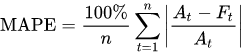

As the denominator can be zero or values close to zero in some cases the mape can be so so huge

We can interpret the MAE errors as the number of  (j) energy deviation on average across the whole dataset. 

In [398]:
y_true = multivar_df['Heating']
y_preds_persistance_1_day = y_true.shift(24).dropna()
persistence_1_day_mae = tf.keras.losses.MAE(y_true[y_preds_persistance_1_day.index], y_preds_persistance_1_day).numpy()
persistence_1_day_mape = tf.keras.losses.MAPE(np.maximum(y_true[y_preds_persistance_1_day.index], 1), np.maximum(y_preds_persistance_1_day, 1)).numpy()
persistence_1_day_mse = tf.keras.losses.MSE(np.maximum(y_true[y_preds_persistance_1_day.index], 1), np.maximum(y_preds_persistance_1_day, 1)).numpy()

shift_dfs = list()
for i in range(1, 4):
    shift_dfs.append(pd.Series(y_true.shift(24 * i), name=f"d{i}"))

y_persistance_3d = pd.concat(shift_dfs, axis=1).dropna()
y_persistance_3d["avg"] = (y_persistance_3d["d1"] + y_persistance_3d["d2"] + y_persistance_3d["d3"])/3
d3_idx = y_persistance_3d.index
persistence_3day_avg_mae = tf.keras.losses.MAE(y_true[d3_idx], y_persistance_3d['avg']).numpy()
persistence_3day_avg_mape = tf.keras.losses.MAPE(np.maximum(y_true[d3_idx], 1), np.maximum(y_persistance_3d['avg'], 1)).numpy()
persistence_3day_avg_mse = tf.keras.losses.MSE(np.maximum(y_true[d3_idx], 1), np.maximum(y_persistance_3d['avg'], 1)).numpy()

ref_error = pd.DataFrame({
    "Method": [ "Persistence 1 Day", "Persitence 3 Day Avg"],
    "MAE": [
            persistence_1_day_mae,
            persistence_3day_avg_mae,],
    "MSE": [
            persistence_1_day_mse,
            persistence_3day_avg_mse],
    "MAPE":[
            persistence_1_day_mape,
            persistence_3day_avg_mape]}, 
    index=[i for i in range(2)])

print("\nSummary of Baseline Errors")
print(ref_error)


Summary of Baseline Errors
                 Method        MAE         MSE        MAPE
0     Persistence 1 Day  11.694488  734.057219  180.391295
1  Persitence 3 Day Avg  11.135568  537.337644  189.549570


# Splitting the Dataset into traing and testing 

In [435]:
def split_data(series):
    """Splits input series into train, val and test.
    """
    train_data = series[:5000]
    
    test_data = series[5000:]
    
    return train_data , test_data

In [436]:
train_multi, test_multi = split_data(multivar_df)

Text(0.5, 0, 'time')

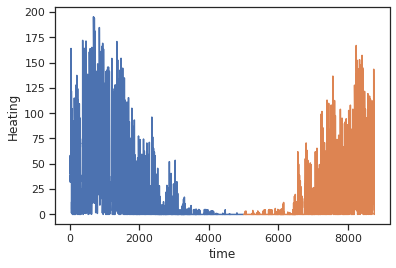

In [439]:
plt.plot(train_multi['Heating'])
plt.plot(test_multi['Heating'])
plt.ylabel('Heating')
plt.xlabel('time')

# turning time series problem into a supervised learning 

In [440]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

## For Training 
# define input sequence
in_seq1 = train_multi['Outdoor Air Temperature'].values
in_seq2 = train_multi['Heating'].values
in_seq3 = train_multi['Occupancy Schedule'].values
in_seq4 = train_multi['dayofw'].values
out_seq = train_multi['Heating'].values
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2,in_seq3, in_seq4,out_seq))
dataset.shape

(5000, 5)

In [441]:
## For testing 
in_seq1_test = test_multi['Outdoor Air Temperature'].values
in_seq2_test = test_multi['Heating'].values
in_seq3_test = test_multi['Occupancy Schedule'].values
in_seq4_test = test_multi['dayofw'].values
out_seq_test = test_multi['Heating'].values
# convert to [rows, columns] structure
in_seq1_test = in_seq1_test.reshape((len(in_seq1_test), 1))
in_seq2_test = in_seq2_test.reshape((len(in_seq2_test), 1))
in_seq3_test = in_seq3_test.reshape((len(in_seq3_test), 1))
in_seq4_test = in_seq4_test.reshape((len(in_seq4_test), 1))
out_seq_test = out_seq_test.reshape((len(out_seq_test), 1))
# horizontally stack columns
dataset_test = hstack((in_seq1_test, in_seq2_test,in_seq3_test,in_seq4_test, out_seq_test))

In [444]:
train_multi.head(20)

Outdoor Air Temperature  Occupancy Schedule  dayofw    Heating
0                -19.908333                0.00       1  53.656294
1                -21.991667                0.00       1  42.031110
2                -22.258333                0.00       1  50.882364
3                -23.583333                0.00       1  41.584953
4                -24.908333                0.00       1  54.480688
5                -25.141667                0.00       1  43.346443
6                -25.216667                0.05       1  53.987876
7                -25.125000                0.05       1  44.600104
8                -25.000000                0.05       1  58.235493
9                -24.941667                0.05       1  46.409059
10               -24.666667                0.05       1  54.186390
11               -23.158333                0.05       1  34.978470
12               -21.208333                0.05       1  40.606030
13               -19.858333                0.05       1  31.769995
14               -19.225000                0.05       1  38.754072
15               -18.341667                0.05       1  32.933000
16               -18.150000                0.05       1  46.483718
17               -18.516667                0.05       1  39.265330
18               -18.250000                0.00       1  50.772860
19               -18.116667                0.00       1  39.887929

In [443]:
# choose a number of time steps
n_steps_in, n_steps_out = 8, 4
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)
# summarize the data
X1, y1 = split_sequences(dataset_test, n_steps_in, n_steps_out)
print(X1.shape, y1.shape)
# Looking to first ten samples 
for i in range(10):
	print(X[i], y[i])

(4989, 8, 4) (4989, 4)
(3749, 8, 4) (3749, 4)
[[-1.99083333e+01  5.36562937e+01  0.00000000e+00  1.00000000e+00]
 [-2.19916667e+01  4.20311097e+01  0.00000000e+00  1.00000000e+00]
 [-2.22583333e+01  5.08823637e+01  0.00000000e+00  1.00000000e+00]
 [-2.35833333e+01  4.15849529e+01  0.00000000e+00  1.00000000e+00]
 [-2.49083333e+01  5.44806878e+01  0.00000000e+00  1.00000000e+00]
 [-2.51416667e+01  4.33464434e+01  0.00000000e+00  1.00000000e+00]
 [-2.52166667e+01  5.39878764e+01  5.00000000e-02  1.00000000e+00]
 [-2.51250000e+01  4.46001036e+01  5.00000000e-02  1.00000000e+00]] [58.23549323 46.40905851 54.18639032 34.97846983]
[[-2.19916667e+01  4.20311097e+01  0.00000000e+00  1.00000000e+00]
 [-2.22583333e+01  5.08823637e+01  0.00000000e+00  1.00000000e+00]
 [-2.35833333e+01  4.15849529e+01  0.00000000e+00  1.00000000e+00]
 [-2.49083333e+01  5.44806878e+01  0.00000000e+00  1.00000000e+00]
 [-2.51416667e+01  4.33464434e+01  0.00000000e+00  1.00000000e+00]
 [-2.52166667e+01  5.39878764e+0

In [445]:
test_multi.head(20)

Outdoor Air Temperature  Occupancy Schedule  dayofw  Heating
5000                23.291667            0.950000       6      0.0
5001                24.141667            0.975703       6      0.0
5002                24.833333            0.950000       6      0.0
5003                25.816667            0.513528       6      0.0
5004                26.458333            0.950000       6      0.0
5005                25.275000            0.975703       6      0.0
5006                23.525000            0.950000       6      0.0
5007                22.316667            0.950000       6      0.0
5008                23.241667            0.300000       6      0.0
5009                25.425000            0.100000       6      0.0
5010                26.183333            0.100000       6      0.0
5011                26.041667            0.100000       6      0.0
5012                24.775000            0.100000       6      0.0
5013                22.850000            0.050000       6      0.0
5014                21.866667            0.050000       6      0.0
5015                20.825000            0.000000       0      0.0
5016                19.850000            0.000000       0      0.0
5017                18.841667            0.000000       0      0.0
5018                17.775000            0.000000       0      0.0
5019                16.525000            0.000000       0      0.0

In [446]:
X1, y1 = split_sequences(dataset_test, n_steps_in, n_steps_out)
print(X1.shape, y1.shape)
# Looking to first ten samples 
for i in range(10):
	print(X1[i], y1[i])

(3749, 8, 4) (3749, 4)
[[23.29166667  0.          0.95        6.        ]
 [24.14166667  0.          0.97570323  6.        ]
 [24.83333333  0.          0.95        6.        ]
 [25.81666667  0.          0.51352801  6.        ]
 [26.45833333  0.          0.95        6.        ]
 [25.275       0.          0.97570323  6.        ]
 [23.525       0.          0.95        6.        ]
 [22.31666667  0.          0.95        6.        ]] [0. 0. 0. 0.]
[[24.14166667  0.          0.97570323  6.        ]
 [24.83333333  0.          0.95        6.        ]
 [25.81666667  0.          0.51352801  6.        ]
 [26.45833333  0.          0.95        6.        ]
 [25.275       0.          0.97570323  6.        ]
 [23.525       0.          0.95        6.        ]
 [22.31666667  0.          0.95        6.        ]
 [23.24166667  0.          0.3         6.        ]] [0. 0. 0. 0.]
[[24.83333333  0.          0.95        6.        ]
 [25.81666667  0.          0.51352801  6.        ]
 [26.45833333  0.          0.

In [447]:
print(X.shape, y.shape)
print(X1.shape, y1.shape)

(4989, 8, 4) (4989, 4)
(3749, 8, 4) (3749, 4)


We can see that the shape of the input portion of the samples is three-dimensional, comprised of 95 samples, with four time steps, and two variables for the 2 input time series.

The output portion of the samples is two-dimensional for the 95 samples and the two time steps for each sample to be predicted.

# Developing Algorithm

In [78]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
n_features

4

In [79]:

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
#model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
#model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out , activation='relu'))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)

# Saving and Loadig the model

https://www.geeksforgeeks.org/save-and-load-models-in-tensorflow/

In [80]:
# saving and loading the .h5 model
from keras.models import Model
from keras.models import load_model
# save model
model.save('next4hoursusingpast8hours.h5')
print('Model Saved!')

Model Saved!


# Loading the model

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
#model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
#model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out , activation='relu'))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [ ]:
# load model
savedModel=load_model(' :) .h5')
savedModel.summary()

# PostProcessing and data analysing

In [448]:
yhat1 = model.predict(X1, verbose=0)
yhat1.shape

(3749, 4)

In [410]:
from matplotlib import pyplot as plt

In [449]:
df_prediction = pd.DataFrame(yhat1, columns = ['predicted Heating next hr','predicted Heating next 2hr','predicted Heating next 3hr','predicted Heating next 4hr' ])
df_realvalues = pd.DataFrame(y1, columns = ['Heating next hr','Heating next 2hr','Heating next 3hr','Heating next 4hr' ])

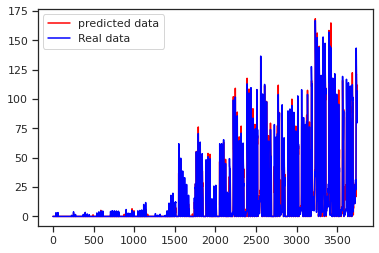

In [412]:
plt.plot(df_prediction['predicted Heating next hr'], color = 'red', label = 'predicted data')
plt.plot(df_realvalues['Heating next hr'], color = 'blue', label='Real data')
plt.legend()
plt.show()

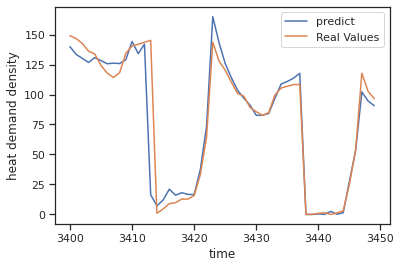

In [413]:

plt.plot(df_prediction['predicted Heating next hr'][3400:3450], label = "predict")
plt.plot(df_realvalues['Heating next hr'][3400:3450], label = 'Real Values')

plt.ylabel('heat demand density')
plt.xlabel('time')
plt.legend()
plt.show()

In [414]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.divide(residual, total))
  return r2

In [415]:
pred_1 =  df_prediction['predicted Heating next hr']
Real_1 =  df_realvalues['Heating next hr']

In [416]:
# Compute Metrics 
# for all samples in test data
print(tf.keras.metrics.mean_absolute_error(pred_1,Real_1).numpy())
print(tf.keras.metrics.mean_squared_error(pred_1,Real_1).numpy())
print(tf.keras.metrics.mean_squared_logarithmic_error(pred_1,Real_1).numpy())

2.0365430722746374
30.81060348302095
0.12049432977497616


In [417]:
R_squared(Real_1,pred_1)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9680740577459161>

# lest do some thing Fun :)

In [ ]:
'''
for x in df_prediction:
  print(len(df_prediction))

for x in df_realvalues:
  print(len(df_realvalues))
'''

3749
3749
3749
3749
3749
3749
3749
3749


So there must be some NAN arrays in both df_prediction and df_realvalues

In [ ]:
'''
Analyze_df1 = pd.concat([df_realvalues,df_prediction], axis=1)
Analyze_df1
'''

I used 8 hours in thap past to predict the next four hours so the fisrt 8 hours of my test_multi will not be precited

In [457]:
df_prediction['predicted Heating next hr'] = df_prediction['predicted Heating next hr'].shift(8)
df_prediction['predicted Heating next 2hr'] = df_prediction['predicted Heating next 2hr'].shift(9)
df_prediction['predicted Heating next 3hr'] = df_prediction['predicted Heating next 3hr'].shift(10)
df_prediction['predicted Heating next 4hr'] = df_prediction['predicted Heating next 4hr'].shift(11)

In [458]:
'''
df_realvalues['Heating next hr'] = df_realvalues['Heating next hr'].shift(8)
df_realvalues['Heating next 2hr'] = df_realvalues['Heating next 2hr'].shift(9)
df_realvalues['Heating next 3hr'] = df_realvalues['Heating next 3hr'].shift(10)
df_realvalues['Heating next 4hr'] = df_realvalues['Heating next 4hr'].shift(11)
'''

In [ ]:
'''
Analyze_df1 = pd.concat([df_realvalues,df_prediction], axis=1)
Analyze_df1.head(20)
'''

In [461]:
#test_multi.dropna(inplace=True)
test_multi = test_multi.reset_index(drop=True)
test_multi

Outdoor Air Temperature  Occupancy Schedule  dayofw     Heating
0                   23.291667            0.950000       6    0.000000
1                   24.141667            0.975703       6    0.000000
2                   24.833333            0.950000       6    0.000000
3                   25.816667            0.513528       6    0.000000
4                   26.458333            0.950000       6    0.000000
...                       ...                 ...     ...         ...
3755               -10.316667            0.000000       1  104.452737
3756               -10.750000            0.000000       1  106.838946
3757               -10.766667            0.000000       1  107.711173
3758               -10.483333            0.000000       1    0.000000
3759               -10.341667            0.000000       1    1.034563

[3760 rows x 4 columns]

In [476]:
Analyze_df = pd.concat([test_multi,df_prediction ], axis=1)

In [477]:
Analyze_df.tail(100)

Outdoor Air Temperature  Occupancy Schedule  dayofw     Heating  \
3660                -7.633333                0.10       4   80.105316   
3661                -7.683333                0.10       4   82.937040   
3662                -7.600000                0.05       4    0.000000   
3663                -7.891667                0.05       4    0.000000   
3664                -7.925000                0.00       5    2.004922   
...                       ...                 ...     ...         ...   
3755               -10.316667                0.00       1  104.452737   
3756               -10.750000                0.00       1  106.838946   
3757               -10.766667                0.00       1  107.711173   
3758               -10.483333                0.00       1    0.000000   
3759               -10.341667                0.00       1    1.034563   

      predicted Heating next hr  predicted Heating next 2hr  \
3660                  79.066483                   74.982437   
3661                  81.153519                   80.417000   
3662                   0.000000                    0.000000   
3663                   0.000000                    0.000000   
3664                   0.000000                    0.000000   
...                         ...                         ...   
3755                        NaN                         NaN   
3756                        NaN                         NaN   
3757                        NaN                         NaN   
3758                        NaN                         NaN   
3759                        NaN                         NaN   

      predicted Heating next 3hr  predicted Heating next 4hr  
3660                   70.042267                   66.558968  
3661                   75.970604                   71.887505  
3662                    0.000000                    0.000000  
3663                    0.000000                    0.000000  
3664                    0.000000                    0.000000  
...                          ...                         ...  
3755                         NaN                         NaN  
3756                         NaN                         NaN  
3757                         NaN                         NaN  
3758                         NaN                         NaN  
3759                         NaN                         NaN  

[100 rows x 8 columns]

In [479]:
day0 = Analyze_df[Analyze_df['dayofw'] == 0]
day1 = Analyze_df[Analyze_df['dayofw'] == 1] 
day2 = Analyze_df[Analyze_df['dayofw'] == 2] 
day3 = Analyze_df[Analyze_df['dayofw'] == 3] 
day4 = Analyze_df[Analyze_df['dayofw'] == 4]
day5 = Analyze_df[Analyze_df['dayofw'] == 5] 
day6 = Analyze_df[Analyze_df['dayofw'] == 6] 

In [480]:
day0

Outdoor Air Temperature  Occupancy Schedule  dayofw    Heating  \
15                  20.825000                 0.0       0   0.000000   
16                  19.850000                 0.0       0   0.000000   
17                  18.841667                 0.0       0   0.000000   
18                  17.775000                 0.0       0   0.000000   
19                  16.525000                 0.0       0   0.000000   
...                       ...                 ...     ...        ...   
3731                -9.925000                 0.0       0  25.882809   
3732               -10.650000                 0.0       0  21.629502   
3733               -11.191667                 0.0       0  27.276843   
3734               -11.750000                 0.0       0  23.280171   
3735               -12.583333                 0.0       0  31.225634   

      predicted Heating next hr  predicted Heating next 2hr  \
15                     0.000000                    0.000000   
16                     0.000000                    0.000000   
17                     0.000000                    0.000000   
18                     0.000000                    0.000000   
19                     0.000000                    0.000000   
...                         ...                         ...   
3731                  22.487938                   20.744957   
3732                  21.977976                   18.379864   
3733                  27.523756                   26.119333   
3734                  21.022966                   22.155369   
3735                  28.908756                   26.146717   

      predicted Heating next 3hr  predicted Heating next 4hr  
15                      0.000000                    0.000000  
16                      0.000000                    0.000000  
17                      0.000000                    0.000000  
18                      0.000000                    0.000000  
19                      0.000000                    0.000000  
...                          ...                         ...  
3731                   14.516335                   13.320081  
3732                   16.739431                   13.141073  
3733                   18.887617                   19.014513  
3734                   22.167343                   16.162691  
3735                   22.613476                   24.467470  

[552 rows x 8 columns]

# testing the model with any data

(3749, 8, 4) (3749, 4)
[[23.29166667  0.          0.95        6.        ]
 [24.14166667  0.          0.97570323  6.        ]
 [24.83333333  0.          0.95        6.        ]
 [25.81666667  0.          0.51352801  6.        ]
 [26.45833333  0.          0.95        6.        ]
 [25.275       0.          0.97570323  6.        ]
 [23.525       0.          0.95        6.        ]
 [22.31666667  0.          0.95        6.        ]] [0. 0. 0. 0.]
[[24.14166667  0.          0.97570323  6.        ]
 [24.83333333  0.          0.95        6.        ]
 [25.81666667  0.          0.51352801  6.        ]
 [26.45833333  0.          0.95        6.        ]
 [25.275       0.          0.97570323  6.        ]
 [23.525       0.          0.95        6.        ]
 [22.31666667  0.          0.95        6.        ]
 [23.24166667  0.          0.3         6.        ]] [0. 0. 0. 0.]
[[24.83333333  0.          0.95        6.        ]
 [25.81666667  0.          0.51352801  6.        ]
 [26.45833333  0.          0.

In [ ]:
'''
# predicting next 2 hours using past three hours / this is for testing our model 
x_input = array([[3.9,2.87 ], [2.9, 2.4], [1.2, 3.8] ])
x_input = x_input.reshape((1, n_steps_in, n_features))
print(x_input.shape)
yhat = model.predict(x_input, verbose=0)
print(yhat)
'''

# filtering tha Peaks

Zscore = (data_point -mean) / std. deviation

Z- Score is also called a standard score. This value/score helps to understand that how far is the data point from the mean. And after setting up a threshold value one can utilize z score values of data points to define the outliers.

Now to define an outlier threshold value is chosen which is generally 3.0. As 99.7% of the data points lie between +/- 3 standard deviation (using Gaussian Distribution approach).

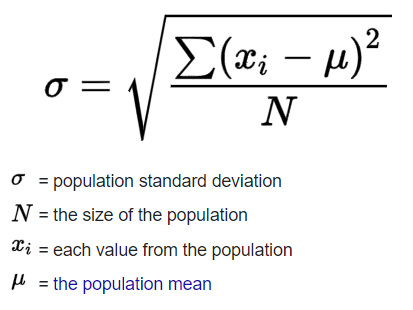

Text(0.5, 0, 'time')

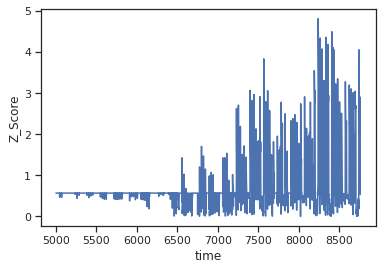

In [ ]:
from scipy import stats
z = np.abs(stats.zscore(test_multi['Heating']))
plt.plot(z)
plt.ylabel('Z_Score')
plt.xlabel('time')

In [ ]:
test_multi.describe()

Outdoor Air Temperature  Occupancy Schedule       dayofw      Heating
count              3760.000000         3760.000000  3760.000000  3760.000000
mean                  4.811908            0.279573     2.979521    17.643810
std                  12.631838            0.381415     2.013087    31.072090
min                 -24.975000            0.000000     0.000000     0.000000
25%                  -5.135417            0.000000     1.000000     0.000000
50%                   4.162500            0.100000     3.000000     0.000000
75%                  15.700000            0.513528     5.000000    24.312670
max                  31.875000            0.975703     6.000000   166.867142

In [ ]:
threshold = 3
# Position of the outlier
filterq= np.where(z>3)
filterq

(array([2399, 2567, 2568, 2615, 3191, 3192, 3193, 3194, 3200, 3239, 3240,
        3241, 3242, 3243, 3244, 3245, 3246, 3248, 3249, 3250, 3251, 3252,
        3253, 3263, 3264, 3265, 3266, 3267, 3268, 3273, 3274, 3275, 3276,
        3277, 3287, 3288, 3289, 3311, 3324, 3325, 3335, 3336, 3337, 3338,
        3339, 3340, 3345, 3346, 3347, 3348, 3349, 3359, 3360, 3361, 3362,
        3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417,
        3418, 3419, 3420, 3421, 3431, 3432, 3433, 3455, 3479, 3575, 3623,
        3647, 3671, 3695, 3743, 3744, 3745, 3746]),)

In [ ]:
df_1 = test_multi.filter(items= [2399, 2567, 2568, 2615, 3191, 3192, 3193, 3194, 3200, 3239, 3240,
        3241, 3242, 3243, 3244, 3245, 3246, 3248, 3249, 3250, 3251, 3252,
        3253, 3263, 3264, 3265, 3266, 3267, 3268, 3273, 3274, 3275, 3276,
        3277, 3287, 3288, 3289, 3311, 3324, 3325, 3335, 3336, 3337, 3338,
        3339, 3340, 3345, 3346, 3347, 3348, 3349, 3359, 3360, 3361, 3362,
        3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417,
        3418, 3419, 3420, 3421, 3431, 3432, 3433, 3455, 3479, 3575, 3623,
        3647, 3671, 3695, 3743, 3744, 3745, 3746], axis=0)

# CNN and other models